In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
import seaborn as sns

In [5]:
#実際のデータは55000000個ある。でかすぎる…
#今回はその1/10000
df = pd.read_csv('train.csv', nrows=5500)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# pickup_longitude=客を乗せた経度 pickup_latitude=客を乗せた緯度

In [6]:
#欠損値,型を確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 8 columns):
key                  5500 non-null object
fare_amount          5500 non-null float64
pickup_datetime      5500 non-null object
pickup_longitude     5500 non-null float64
pickup_latitude      5500 non-null float64
dropoff_longitude    5500 non-null float64
dropoff_latitude     5500 non-null float64
passenger_count      5500 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 343.8+ KB


In [8]:
#明らかに誤記入のデータをクリーニングする必要がある。
#fate_amount = -44.900000, pickup_longtitude = -3377.680935はおかしい
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000
mean,11.256302,-72.473464,39.895626,-72.472922,39.903388,1.628000
std,9.594921,10.554915,6.226075,10.554848,6.202621,1.256291
min,-2.900000,-74.438233,-73.991840,-74.429332,-73.979010,0.000000
25%,6.000000,-73.992394,40.734187,-73.991364,40.734319,1.000000
50%,8.500000,-73.982040,40.752137,-73.980325,40.753405,1.000000
75%,12.500000,-73.967081,40.766718,-73.963938,40.767274,2.000000
max,180.000000,40.751582,41.366138,40.758867,41.032598,6.000000


In [9]:
#欠損値の数を表示
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [10]:
#欠損値のある行を削除
df = df.dropna()
df.shape

(5500, 8)

# 1:運賃の前処理

In [11]:
#料金が正の値のみを抽出
df = df[df['fare_amount'] > 0]
df.shape

(5498, 8)

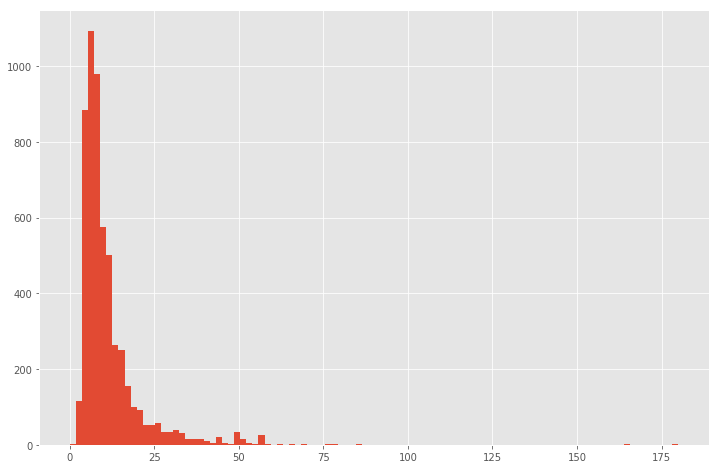

In [12]:
#fare_amountの分布を確認
#外れ値を探せる手法
plt.figure(figsize=(12, 8))
plt.hist(df['fare_amount'], bins=100)
plt.show()

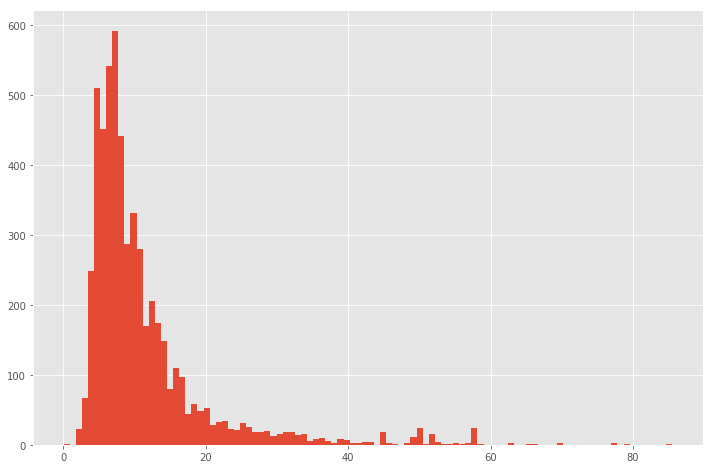

In [13]:
#とりあえず、データを100ドル以下に絞る
df = df[df['fare_amount'] < 100]
plt.figure(figsize=(12, 8))
plt.hist(df['fare_amount'], bins=100)
plt.show()

# 四分位数を使った方法(四分位範囲の1.5倍以上はなれているものを除外)

In [14]:
#外れ値の処理の続き
def outlier_iqr(df, columns=None):
    if columns == None:
        columns = df.columns

    for col in columns:
        q1 = df[col].describe()['25%']
        q3 = df[col].describe()['75%']
        #四分位範囲
        iqr = q3 - q1 
        
        outlier_min = q1 - iqr * 1.5
        outlier_max = q3 + iqr * 1.5

        # 範囲から外れている値を除く
        df = df[(df[col] >= outlier_min) & (df[col] <= outlier_max)]
        
    return df

In [15]:
print('before', df.shape)
df = outlier_iqr(df, columns=['fare_amount'])
print('after', df.shape)

before (5496, 8)
after (5029, 8)


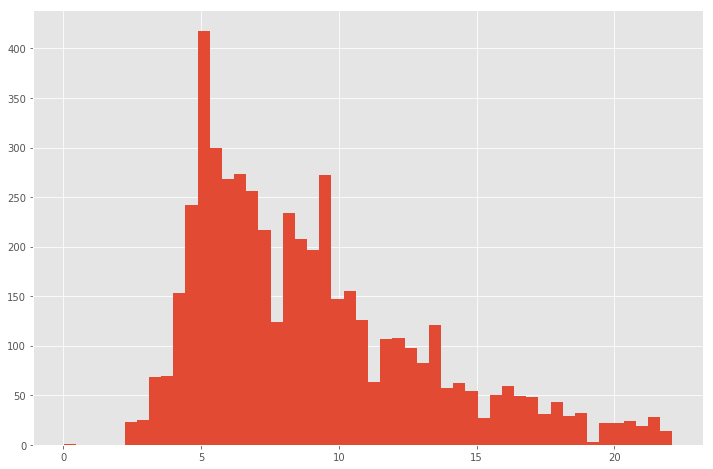

In [16]:
#それなりにいい形になった
plt.figure(figsize=(12, 8))
plt.hist(df['fare_amount'], bins=50)
plt.show()

# 2:経度・緯度の前処理

# ニューヨークの経度 -74° 緯度　41°　

In [17]:
# 経度・緯度 +-1°で絞る
print('before', df.shape)
df = df[(df['pickup_longitude'] > -75) & (df['pickup_longitude'] < -73)]
df = df[(df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42)]
df = df[(df['dropoff_longitude'] > -75) & (df['dropoff_longitude'] < -73)]
df = df[(df['dropoff_latitude'] > 40) & (df['dropoff_latitude'] < 42)]
print('after', df.shape)

before (5029, 8)
after (4925, 8)


# 3:乗客数の前処理

In [18]:
#分布の形を確認
df['passenger_count'].value_counts()

1    3519
2     668
5     327
3     216
6      89
4      88
0      18
Name: passenger_count, dtype: int64

In [19]:
#乗客=0を取り除けばいいことがわかる
print('before', df.shape)
df = df[(df['passenger_count'] > 0)]
print('after', df.shape)

before (4925, 8)
after (4907, 8)


In [20]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000
mean,8.955531,-73.979376,40.752170,-73.978433,40.752123,1.635215
std,4.128516,0.030721,0.028737,0.023234,0.026492,1.260992
min,0.010000,-74.017288,40.614803,-74.177023,40.484335,1.000000
25%,5.700000,-73.992858,40.736463,-73.991884,40.736987,1.000000
50%,8.000000,-73.982620,40.752693,-73.981360,40.754157,1.000000
75%,11.000000,-73.969983,40.766678,-73.968097,40.766831,2.000000
max,22.100000,-73.137393,41.366138,-73.719100,40.954298,6.000000


# クリーニング終了

# 特徴エンジニアリング(オリジナルデータから新たな情報を抜き出す)

## 「pickup_datetime」→「~年,~月,~時」　「緯度・経度」→「～km移動したのか・どの方向に移動したのか」

# 球面三角法を使った2地点間の距離の計算
# 方角の計算

In [21]:
#距離の計算
def calculation_distance(x_1, y_1, x_2, y_2):
    # 赤道半径 (km)
    R = 6371
    # Radian角に変換
    _x1, _y1, _x2, _y2  = map(np.radians, [x_1, y_1, x_2, y_2])
    
    delta_x = _x2 - _x1
    delta_y = _y2 - _y1
    
    # 距離を計算
    a = np.sin(delta_y/2.0)**2 + np.cos(_y1) * np.cos(_y2) * np.sin(delta_x/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

#方角の計算
def calculation_azimuth(x_1, y_1, x_2, y_2):
    # Radian角に修正
    _x1, _y1, _x2, _y2 = map(np.radians, [x_1, y_1, x_2, y_2])
    
    delta_x = _x2 - _x1
    _y = np.sin(delta_x)
    _x = np.cos(_y1) * np.tan(_y2) - np.sin(_y1) * np.cos(delta_x)

    psi = np.rad2deg(np.arctan2(_y, _x))
    
    return np.where(psi < 0, 360 + psi, psi)

In [22]:
#距離のカラムを作成
df['distance'] = calculation_distance(df['pickup_longitude'],
                                      df['pickup_latitude'],
                                      df['dropoff_longitude'],
                                      df['dropoff_latitude'])
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157


In [23]:
#方角のカラムを作成
df['azimuth'] = calculation_azimuth(df['pickup_longitude'],
                                    df['pickup_latitude'],
                                    df['dropoff_longitude'],
                                    df['dropoff_latitude'])
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,azimuth
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,167.240469
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,21.498365
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,211.033211
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,352.327836
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,28.802783


In [24]:
#日時のデータから特徴量を取得
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['year'] = df['pickup_datetime'].dt.year

df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,azimuth,hour,day,month,dayofweek,year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,167.240469,17,15,6,0,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,21.498365,16,5,1,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,211.033211,0,18,8,3,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,352.327836,4,21,4,5,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,28.802783,7,9,3,1,2010


# やっとモデル構築

In [25]:
# 勾配ブースティングはkaggleで頻繁に上位にくる手法
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [26]:
#不要カラム削除
X = df.drop(columns=['key', 'fare_amount', 'pickup_datetime']) #説明変数
y = df['fare_amount'] #目的変数

print(X.shape)
print(y.shape)

(4907, 12)
(4907,)


In [27]:
print(len(X.columns))

12


In [28]:
X.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'distance', 'azimuth', 'hour',
       'day', 'month', 'dayofweek', 'year'],
      dtype='object')

In [29]:
#訓練データを訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)
print(X_train.shape)
print(X_test.shape)

(3925, 12)
(982, 12)


In [30]:
#xgboostはパラメータを決める必要がある…
params = {
    'silent': 1, #どうでもよい
    'max_depth': 6, #決定木の個数?
    'min_child_weight': 1,
    'eta': 0.1, #学習率(どのくらいのスピードで学習するか)
    'tree_method': 'exact',
    'objective': 'reg:linear',#回帰分析だからreg:linear
    'eval_metric': 'rmse', #二乗誤差を評価の基準に
    'predictor': 'cpu_predictor' #どうでもよい
}

# params = {
#     'silent': 1,
#     'max_depth': 6,
#     'min_child_weight': 1,
#     'eta': 0.1,
#     'tree_method': 'gpu_exact',
#     'objective': 'gpu:reg:linear',
#     'eval_metric': 'rmse',
#     'predictor': 'gpu_predictor'
# }

#xgboostをするには特殊な行列が必要…
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=1000, #1000個の決定木を重ねる
                  early_stopping_rounds=5, #5回連続で性能が上昇しなければそこで終了
                  evals=[(dtest, 'test')])

#つまり,1000回調整をするか、5回連続で性能が上昇しない点で止まるか

[0]	test-rmse:8.52693
Will train until test-rmse hasn't improved in 5 rounds.
[1]	test-rmse:7.74526
[2]	test-rmse:7.04625
[3]	test-rmse:6.42359
[4]	test-rmse:5.86927
[5]	test-rmse:5.37025
[6]	test-rmse:4.93316
[7]	test-rmse:4.54215
[8]	test-rmse:4.19679
[9]	test-rmse:3.89377
[10]	test-rmse:3.62489
[11]	test-rmse:3.40400
[12]	test-rmse:3.20402
[13]	test-rmse:3.02708
[14]	test-rmse:2.87939
[15]	test-rmse:2.75536
[16]	test-rmse:2.63889
[17]	test-rmse:2.53883
[18]	test-rmse:2.45531
[19]	test-rmse:2.38766
[20]	test-rmse:2.32764
[21]	test-rmse:2.28208
[22]	test-rmse:2.23891
[23]	test-rmse:2.19735
[24]	test-rmse:2.16869
[25]	test-rmse:2.14184
[26]	test-rmse:2.12007
[27]	test-rmse:2.10051
[28]	test-rmse:2.08515
[29]	test-rmse:2.06996
[30]	test-rmse:2.05827
[31]	test-rmse:2.05020
[32]	test-rmse:2.04550
[33]	test-rmse:2.03536
[34]	test-rmse:2.03035
[35]	test-rmse:2.02429
[36]	test-rmse:2.01980
[37]	test-rmse:2.01228
[38]	test-rmse:2.00889
[39]	test-rmse:2.00685
[40]	test-rmse:2.00406
[41]	test-r

## グリッドサーチでハイパーパラメータを最適化

In [31]:
#しらみ潰しに全部試す
gridsearch_params = [
    (max_depth, eta)
    for max_depth in [6, 7, 8] #データによってrandom
    for eta in [0.1, 0.05, 0.01] #データによってrandom
]
gridsearch_params

[(6, 0.1),
 (6, 0.05),
 (6, 0.01),
 (7, 0.1),
 (7, 0.05),
 (7, 0.01),
 (8, 0.1),
 (8, 0.05),
 (8, 0.01)]

In [32]:
cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=10,
        seed=0,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=5
    )

In [33]:
# num_boost_round=1000
# test-rmse-stdが最小になってほしい
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,8.526295,0.044828,8.526002,0.177854
1,7.732531,0.040950,7.735033,0.159655
2,7.021761,0.037438,7.032505,0.143533
3,6.385455,0.034833,6.403619,0.132166
4,5.816514,0.032454,5.845612,0.121153
5,5.308062,0.030484,5.350397,0.112835
6,4.853619,0.028849,4.910948,0.108090
7,4.449078,0.027435,4.522572,0.101256
8,4.087863,0.026062,4.181811,0.098994
9,3.766814,0.024445,3.882862,0.096800


In [34]:
#めっちゃ時間がかかるので、最初のデータを少なくした方がいいかも
#どのハイパーパラメータがいいのかを知る
min_rmse = float('Inf') #初期値を無限大にする(atcorderっぽい)
best_param = []

for max_depth, eta in gridsearch_params:
    print('max_depth={}, eta={}'.format(max_depth, eta))
    
    params['max_depth'] = max_depth
    params['eta'] = eta
    
    #交差検証
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000,
        seed=0,
        nfold=5, #5回繰り返す
        metrics={'rmse'},
        early_stopping_rounds=5
    )
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin() #何回目の学習で最終的な値を取り出せたか
    print('RMSE {} for {} rounds'.format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_param = (max_depth, eta)
    
print('Best params {}, RMSE {}'.format(best_param, min_rmse))

max_depth=6, eta=0.1


C:\Users\tomoh\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


RMSE 1.9703996 for 106 rounds
max_depth=6, eta=0.05
RMSE 1.9552738 for 190 rounds
max_depth=6, eta=0.01
RMSE 1.9606698000000002 for 933 rounds
max_depth=7, eta=0.1
RMSE 2.0026062 for 93 rounds
max_depth=7, eta=0.05
RMSE 1.9820964 for 199 rounds
max_depth=7, eta=0.01
RMSE 1.9882252 for 856 rounds
max_depth=8, eta=0.1
RMSE 2.029292 for 79 rounds
max_depth=8, eta=0.05
RMSE 2.0247256 for 185 rounds
max_depth=8, eta=0.01
RMSE 2.0214952 for 781 rounds
Best params (6, 0.05), RMSE 1.9552738


In [35]:
#仮に上の最適ハイパーパラメータは6,0.05なら
params['max_depth'] = 6
params['eta'] = 0.05

model = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=1000,
                  early_stopping_rounds=5,
                  evals=[(dtest, 'test')])

[0]	test-rmse:8.96174
Will train until test-rmse hasn't improved in 5 rounds.
[1]	test-rmse:8.54833
[2]	test-rmse:8.15561
[3]	test-rmse:7.78430
[4]	test-rmse:7.43008
[5]	test-rmse:7.09767
[6]	test-rmse:6.78073
[7]	test-rmse:6.48319
[8]	test-rmse:6.19946
[9]	test-rmse:5.93400
[10]	test-rmse:5.67930
[11]	test-rmse:5.44012
[12]	test-rmse:5.21677
[13]	test-rmse:5.00624
[14]	test-rmse:4.80833
[15]	test-rmse:4.61848
[16]	test-rmse:4.44081
[17]	test-rmse:4.27564
[18]	test-rmse:4.11749
[19]	test-rmse:3.97230
[20]	test-rmse:3.83372
[21]	test-rmse:3.70785
[22]	test-rmse:3.58407
[23]	test-rmse:3.47200
[24]	test-rmse:3.36946
[25]	test-rmse:3.26923
[26]	test-rmse:3.17479
[27]	test-rmse:3.08848
[28]	test-rmse:3.00622
[29]	test-rmse:2.93346
[30]	test-rmse:2.86434
[31]	test-rmse:2.79828
[32]	test-rmse:2.73725
[33]	test-rmse:2.68193
[34]	test-rmse:2.63001
[35]	test-rmse:2.58045
[36]	test-rmse:2.53451
[37]	test-rmse:2.49341
[38]	test-rmse:2.45425
[39]	test-rmse:2.41935
[40]	test-rmse:2.38658
[41]	test-r

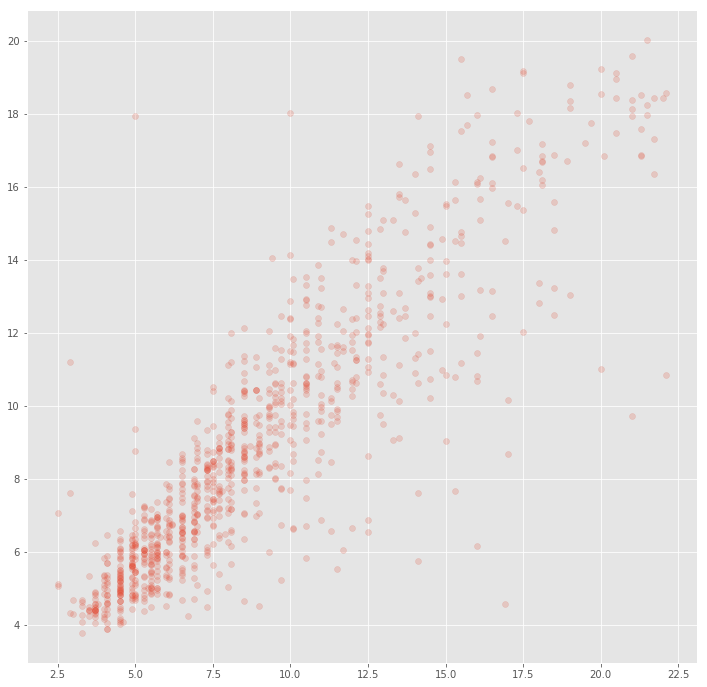

In [36]:
#横軸=正解値,縦軸=予測値
#傾き=1の直線が理想
prediction = model.predict(xgb.DMatrix(X_test), 
                           ntree_limit=model.best_ntree_limit)

plt.figure(figsize=(12, 12))
plt.scatter(y_test[:1000], prediction[:1000], alpha=0.2)
plt.show()

In [37]:
prediction

array([12.745962 ,  4.645863 , 15.28238  , 13.782024 , 10.143417 ,
        4.0414395, 18.523317 ,  7.2077446,  7.23213  ,  5.6843677,
        6.7360535, 15.633903 ,  9.86285  ,  7.452146 , 12.929983 ,
       11.265172 , 11.930483 , 13.427113 , 10.474448 , 10.050369 ,
        7.7157598,  8.340905 , 14.115167 ,  9.13112  ,  8.141758 ,
        5.219533 ,  7.690892 ,  9.87052  ,  8.293592 , 14.451178 ,
        5.9852366, 13.027641 ,  5.758086 ,  6.143769 , 12.45796  ,
       12.416747 ,  6.4029217,  4.8196273, 10.222218 ,  6.4630904,
        3.7791605,  4.979888 ,  6.5354204, 19.135015 ,  6.6917505,
       14.064562 ,  6.1986117,  5.4583673,  6.520223 ,  5.6056933,
        5.661128 , 10.176196 , 17.49212  ,  4.4856024, 16.872667 ,
        7.4326706, 10.52033  ,  7.0053816, 11.265848 , 15.553793 ,
       10.688856 ,  5.324264 ,  5.024463 , 14.421352 , 17.948008 ,
        6.9702206,  6.2053165,  8.851535 , 10.641144 ,  5.548854 ,
       10.906433 ,  7.5722938,  5.3790145,  7.4858093, 11.4458

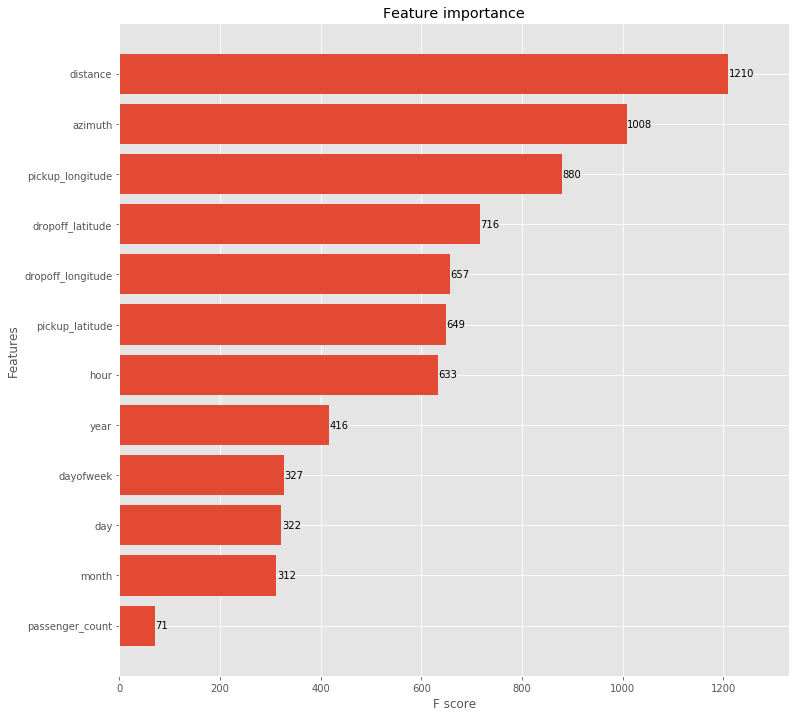

In [38]:
#xgboostの便利な機能
#それぞれの特徴量が予測にどれだけの影響を与えているかを知る魔法
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=12, height=0.8, ax=ax)
plt.show()

# 提出の流れ

In [39]:
DF = pd.read_csv('test.csv')
DF.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


# 「pickup_datetime」と「緯度・経度」の特徴量エンジニアリングをする必要がある。

In [40]:
#日時のデータから特徴量を取得
DF['pickup_datetime'] = pd.to_datetime(DF['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

DF['hour'] = DF['pickup_datetime'].dt.hour
DF['day'] = DF['pickup_datetime'].dt.day
DF['month'] = DF['pickup_datetime'].dt.month
DF['dayofweek'] = DF['pickup_datetime'].dt.dayofweek
DF['year'] = DF['pickup_datetime'].dt.year

DF.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,dayofweek,year
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,13,27,1,1,2015
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,13,27,1,1,2015
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,11,8,10,5,2011
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,21,1,12,5,2012
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,21,1,12,5,2012


In [41]:
#距離のカラムを作成
DF['distance'] = calculation_distance(DF['pickup_longitude'],
                                      DF['pickup_latitude'],
                                      DF['dropoff_longitude'],
                                      DF['dropoff_latitude'])
DF.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,dayofweek,year,distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,13,27,1,1,2015,2.323260
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,13,27,1,1,2015,2.425353
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,11,8,10,5,2011,0.618628
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,21,1,12,5,2012,1.961033
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,21,1,12,5,2012,5.387301


In [42]:
#角度
DF['azimuth'] = calculation_azimuth(DF['pickup_longitude'],
                                    DF['pickup_latitude'],
                                    DF['dropoff_longitude'],
                                    DF['dropoff_latitude'])

In [43]:
DF=DF.drop(columns=["pickup_datetime"])

In [44]:
#不要カラム削除
DF_X = DF.drop(columns=['key']) #説明変数

print(X.shape)
print(y.shape)

(4907, 12)
(4907,)


In [99]:
DF_X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,dayofweek,year,distance,azimuth
0,-73.973320,40.763805,-73.981430,40.743835,1,13,27,1,1,2015,2.323260,197.102591
1,-73.986862,40.719383,-73.998886,40.739201,1,13,27,1,1,2015,2.425353,335.311613
2,-73.982524,40.751260,-73.979654,40.746139,1,11,8,10,5,2011,0.618628,156.994148
3,-73.981160,40.767807,-73.990448,40.751635,1,21,1,12,5,2012,1.961033,203.513308
4,-73.966046,40.789775,-73.988565,40.744427,1,21,1,12,5,2012,5.387301,200.618451


In [47]:
#カラム列を揃える
DF_X=DF[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'distance', 'azimuth', 'hour',
       'day', 'month', 'dayofweek', 'year']]
DF_X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,azimuth,hour,day,month,dayofweek,year
0,-73.973320,40.763805,-73.981430,40.743835,1,2.323260,197.102591,13,27,1,1,2015
1,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,335.311613,13,27,1,1,2015
2,-73.982524,40.751260,-73.979654,40.746139,1,0.618628,156.994148,11,8,10,5,2011
3,-73.981160,40.767807,-73.990448,40.751635,1,1.961033,203.513308,21,1,12,5,2012
4,-73.966046,40.789775,-73.988565,40.744427,1,5.387301,200.618451,21,1,12,5,2012


In [48]:
print(len(DF_X.columns))

12


In [58]:
new_result = np.round(result, decimals=2)
print(new_result)

[10.13 10.51  4.93 ... 11.89 18.53  7.72]


In [59]:
# 予測(提出完了)
result = model.predict(xgb.DMatrix(DF_X),
                      ntree_limit=model.best_ntree_limit)
pd.DataFrame({
    "key": DF["key"],
    "fare_amount": new_result
}).to_csv("result.csv", index=False)